In [1]:
ENV["OMP_NUM_THREADS"] = 40

using PyCall
using XGPaint
using HDF5
using Healpix
using Unitful, UnitfulAstro
nmt = pyimport("pymaster")


PyObject <module 'pymaster' from '/tigress/zequnl/conda_envs/ps/lib/python3.8/site-packages/pymaster/__init__.py'>

In [2]:
using XGPaint
using Healpix
hp = pyimport("healpy")

using PyPlot
PyPlot.svg(true)
using Unitful, UnitfulAstro
import PhysicalConstants.CODATA2018: BoltzmannConstant, PlanckConstant, SpeedOfLightInVacuum

# CHANGE FOR DIFFERENT FREQUENCY ==========================
# print(KCMB_to_Jy_factor(freq * 1u"GHz"))

const TCMB = 2.725u"K"
xf(ν) = float(PlanckConstant) * ν / float(BoltzmannConstant) / TCMB
MJy_mul(ν) = 1.05e3 * expm1(xf(ν))^2 * exp(-xf(ν)) * (ν/100u"GHz")^(-4)
tSZ_mul(ν) = 1e6u"1/K" * TCMB * (xf(ν) * (exp(xf(ν))+1) / expm1(xf(ν)) - 4)

tSZ_mul (generic function with 1 method)

In [3]:
# freq = 143.0
# # int_freq = Int(freq)

# flux_143 = h5read("/tigress/zequnl/radio/lagache_sed_massage/catalog_$(143.0).h5", "flux");
# flux = h5read("/tigress/zequnl/radio/lagache_sed_massage/catalog_$(freq).h5", "flux")
# θ = h5read("/tigress/zequnl/radio/lagache_sed_massage/catalog_$(freq).h5", "theta")
# ϕ = h5read("/tigress/zequnl/radio/lagache_sed_massage/catalog_$(freq).h5", "phi");

In [9]:
function map_from_freq(freq; nside = 4096)
    flux_143 = h5read("/tigress/zequnl/radio/lagache_sed_massage/catalog_$(143.0).h5", "flux");
    flux = h5read("/tigress/zequnl/radio/lagache_sed_massage/catalog_$(freq).h5", "flux")
    θ = h5read("/tigress/zequnl/radio/lagache_sed_massage/catalog_$(freq).h5", "theta")
    ϕ = h5read("/tigress/zequnl/radio/lagache_sed_massage/catalog_$(freq).h5", "phi");
    
    m_radio = HealpixMap{Float64,RingOrder}(nside)
    XGPaint.catalog2map!(m_radio, flux, θ, ϕ)
    MJy_factor = MJy_mul(freq * 1u"GHz")
    m_radio .*= MJy_factor / 1e6;  # CONVERT TO muK, note that our maps are in Jy/sr
    
    return m_radio
end

map_from_freq (generic function with 1 method)

In [7]:
using JLD2
using PowerSpectra
@load "/tigress/zequnl/radio/apodized_15arcmin_7mJy_cut_at_143Ghz_mask.jld2" apo
maskalm = map2alm(apo)
𝐌 = mcm(:TT, maskalm, maskalm)

12288×12288 SpectralArray{Float64, 2, Matrix{Float64}} with indices 0:12287×0:12287:
 0.89785      1.6863e-7    6.68439e-8   …  2.01071e-11  2.02469e-11
 5.62099e-8   0.89785      2.9887e-7       1.96889e-11  1.0054e-11
 1.33688e-8   1.79322e-7   0.897851        1.23642e-11  1.22364e-11
 6.21502e-8   1.56471e-7   2.52554e-7      1.34593e-11  9.88498e-12
 8.1248e-8    1.51059e-7   2.53805e-7      1.11901e-11  1.11534e-11
 4.09151e-8   2.03809e-7   2.75544e-7   …  1.1993e-11   9.80653e-12
 5.68435e-8   1.51194e-7   2.97431e-7      1.06613e-11  1.06586e-11
 5.85261e-8   1.51821e-7   2.27776e-7      1.13165e-11  9.70923e-12
 4.51503e-8   1.48274e-7   2.41771e-7      1.03626e-11  1.03835e-11
 4.13344e-8   1.33003e-7   2.39854e-7      1.08671e-11  9.63878e-12
 4.35999e-8   1.27378e-7   2.51573e-7   …  1.02012e-11  1.01545e-11
 4.3482e-8    1.54435e-7   3.25364e-7      1.06037e-11  9.61658e-12
 5.86999e-8   2.16023e-7   3.37983e-7      1.0088e-11   1.0027e-11
 ⋮                               

In [10]:
@save "/tigress/zequnl/radio/apodized_15arcmin_7mJy_cut_at_143Ghz_mcm.jld2" 𝐌

In [12]:
run(`ls /tigress/zequnl/radio/lagache_sed_massage/`)

catalog_100.0.h5
catalog_111.0.h5
catalog_129.0.h5
catalog_143.0.h5
catalog_153.0.h5
catalog_164.0.h5
catalog_189.0.h5
catalog_210.0.h5
catalog_217.0.h5
catalog_27.3.h5
catalog_30.0.h5
catalog_35.9.h5
catalog_41.7.h5
catalog_44.0.h5
catalog_47.4.h5
catalog_70.0.h5
catalog_73.7.h5
catalog_79.6.h5
catalog_90.2.h5


Process(`ls /tigress/zequnl/radio/lagache_sed_massage/`, ProcessExited(0))

In [15]:
freqs = [27.3, 30.0, 35.9, 41.7, 44.0, 47.4, 70., 73.7, 79.6, 90.2, 100., 
    111., 129., 143., 153., 164., 189., 210., 217.];

In [22]:
function get_poisson_level(freq)
    
    masked_radio = map_from_freq(freq) * apo
    Healpix.applyfullweights!(masked_radio)
    @time alm_radio = map2alm(masked_radio; niter=0)
    pcl_radio_radio = SpectralVector(alm2cl(alm_radio))
    return sum((𝐌 \ pcl_radio_radio)[1500:3000]) / 1500
end

get_poisson_level (generic function with 1 method)

In [23]:
levels = [get_poisson_level(f) for f in freqs]

  6.235481 seconds (15.63 k allocations: 1.126 GiB, 0.09% gc time, 0.21% compilation time)
  6.183370 seconds (9 allocations: 1.125 GiB, 0.05% gc time)
  6.229627 seconds (9 allocations: 1.125 GiB, 0.04% gc time)
  6.242580 seconds (9 allocations: 1.125 GiB, 0.04% gc time)
  6.222598 seconds (9 allocations: 1.125 GiB, 0.04% gc time)
  6.213429 seconds (9 allocations: 1.125 GiB, 0.04% gc time)
  6.219571 seconds (9 allocations: 1.125 GiB, 0.05% gc time)
  6.264034 seconds (9 allocations: 1.125 GiB, 0.06% gc time)
  6.227689 seconds (9 allocations: 1.125 GiB, 0.27% gc time)
  6.223903 seconds (9 allocations: 1.125 GiB, 0.06% gc time)
  6.203168 seconds (9 allocations: 1.125 GiB, 0.04% gc time)
  6.213936 seconds (9 allocations: 1.125 GiB, 0.04% gc time)
  6.217203 seconds (9 allocations: 1.125 GiB, 0.21% gc time)
  6.211440 seconds (9 allocations: 1.125 GiB, 0.05% gc time)
  6.212823 seconds (9 allocations: 1.125 GiB, 0.04% gc time)
  6.204122 seconds (9 allocations: 1.125 GiB, 0.05% gc 

19-element Vector{Float64}:
 0.0031885816942465238
 0.0018676650047054295
 0.0007276542326092857
 0.0003432857605477418
 0.00026105217600361273
 0.00017787125352169966
 2.4046182886613653e-5
 1.8773816067500466e-5
 1.3083785275355856e-5
 7.447413291192607e-6
 4.771857971297577e-6
 3.100755878508525e-6
 1.7435622115184894e-6
 1.2393402239386784e-6
 1.019228085361611e-6
 8.555357378975742e-7
 6.528581209666133e-7
 5.755334663988771e-7
 5.614698743811083e-7

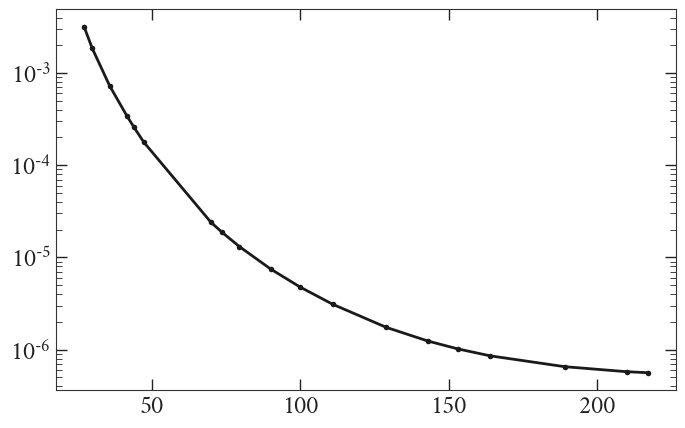

In [29]:
plt.plot(freqs, levels)
plt.yscale("log")
# plt.xscale("log")

In [30]:
fgspectra = pyimport("fgspectra")
fgc = pyimport("fgspectra.cross")
fgp = pyimport("fgspectra.power")
fgf = pyimport("fgspectra.frequency")

np = pyimport("numpy")

PyObject <module 'numpy' from '/tigress/zequnl/conda_envs/ps/lib/python3.8/site-packages/numpy/__init__.py'>

In [35]:
par = Dict(
    "nu_0" => 150.0,
    "ell_0" => 3000,
    "T_CMB" => 2.725,
    "T_d" => 9.7,
    "a_tSZ" => 4.66,
    "a_kSZ" => 1.60,
    "a_p" => 6.87,
    "beta_p" => 2.08,
    "a_c" => 6.10,
    "beta_c" => 2.08,
    "n_CIBC" => 1.20,
    "xi" => 0.09,
    "a_s" => 3.50,
    "a_g" => 0.88,
)

radio = fgc.FactorizedCrossSpectrum(fgf.PowerLaw(), fgp.PowerLaw())
ells = np.arange(1500, 3000)
radio_model = par["a_s"] * radio(
            Dict("nu"=> freqs, "nu_0"=>par["nu_0"], "beta"=>-0.5 - 2),
            Dict("ell"=>ells, "ell_0"=>par["ell_0"], "alpha"=>2))[i,i,1];

In [46]:
models = [par["a_s"] * radio(
            Dict("nu"=> freqs, "nu_0"=>par["nu_0"], "beta"=>-0.5 - 2),
            Dict("ell"=>ells, "ell_0"=>par["ell_0"], "alpha"=>2))[i,i,1] for i in 1:length(freqs)]

19-element Vector{Float64}:
 1513.0227535957222
  951.7217582501157
  395.65929423237475
  191.48581561090515
  147.889014498312
  103.5637885998969
   16.868928636790418
   13.392647086324487
    9.535567137291318
    5.582659485949607
    3.6548569580680956
    2.429803889947209
    1.4113665961382613
    1.0096385700513943
    0.8266784637492998
    0.6858762336335509
    0.5013757756538213
    0.42598776962172225
    0.4105892481469438

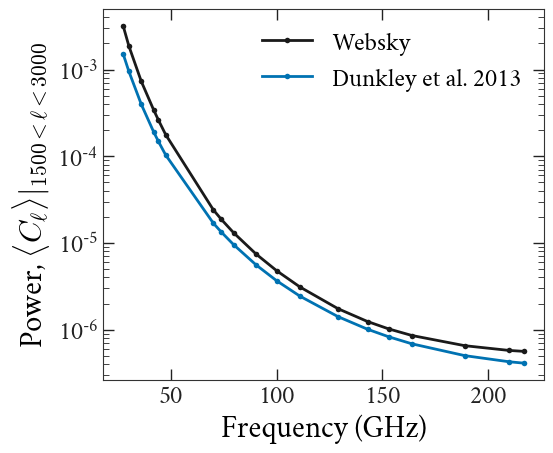

'Cochineal-Roman.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


In [59]:

plt.figure(figsize=(6,5))

plt.plot(freqs, levels, label="Websky")
plt.plot(freqs, models ./ 1e6, label="Dunkley et al. 2013")
plt.yscale("log")
plt.xlabel("Frequency (GHz)")
plt.ylabel(raw"Power, $\langle C_{\ell} \rangle |_{1500<\ell<3000}$")
plt.legend()
plt.tight_layout()
plt.savefig("poisson_power_freq.pdf")
# plt.xlabel()
# plt.xscale("log")

In [45]:
(radio_model ./ dlfac)[1]

0.004225156593253796

In [3]:
nside = 4096
m_radio = HealpixMap{Float64,RingOrder}(nside)

# flux_cut = 7e-3
# cut_array = flux_143 .< flux_cut  # in Jy

XGPaint.catalog2map!(m_radio, flux, θ, ϕ)
MJy_factor = MJy_mul(freq * 1u"GHz")
m_radio .*= MJy_factor / 1e6;  # CONVERT TO muK, note that our maps are in Jy/sr

In [4]:
using PowerSpectra

# compute binning matrix
P = binning_matrix(0:50:2nside, 50:50:2nside+50, ℓ -> ℓ^2, lmax=nside2lmax(nside));
lb = P * collect(0:3nside-1)
pixelwindow = pixwin(nside)[1:nside2lmax(nside)+1];

In [5]:
using FITSIO

m_cib = readMapFromFITS("/tigress/zequnl/websky/cib_nu0$(int_freq).fits", 1, Float64);
m_cib.pixels .*= MJy_factor

tSZ_factor = tSZ_mul(freq * 1u"GHz")
m_tsz = readMapFromFITS("/tigress/zequnl/websky/tsz.fits", 1, Float64);
m_tsz .*= tSZ_factor;

In [7]:
alm_radio = map2alm(m_radio * apo)
alm_cib = map2alm(m_cib * apo)
alm_tsz = map2alm(m_tsz * apo);

In [8]:
pcl_radio_radio = SpectralVector(alm2cl(alm_radio))
pcl_cib_cib = SpectralVector(alm2cl(alm_cib))
pcl_tsz_tsz = SpectralVector(alm2cl(alm_tsz))

pcl_radio_cib = SpectralVector(alm2cl(alm_radio, alm_cib))
pcl_cib_tsz = SpectralVector(alm2cl(alm_cib, alm_tsz))
pcl_radio_tsz = SpectralVector(alm2cl(alm_radio, alm_tsz));

In [9]:
maskalm = map2alm(apo)
𝐌 = mcm(:TT, maskalm, maskalm)

12288×12288 SpectralArray{Float64, 2, Matrix{Float64}} with indices 0:12287×0:12287:
 0.89785      1.6863e-7    6.68439e-8   …  2.01071e-11  2.02469e-11
 5.62099e-8   0.89785      2.9887e-7       1.96889e-11  1.0054e-11
 1.33688e-8   1.79322e-7   0.897851        1.23642e-11  1.22364e-11
 6.21502e-8   1.56471e-7   2.52554e-7      1.34593e-11  9.88498e-12
 8.1248e-8    1.51059e-7   2.53805e-7      1.11901e-11  1.11534e-11
 4.09151e-8   2.03809e-7   2.75544e-7   …  1.1993e-11   9.80653e-12
 5.68435e-8   1.51194e-7   2.97431e-7      1.06613e-11  1.06586e-11
 5.85261e-8   1.51821e-7   2.27776e-7      1.13165e-11  9.70923e-12
 4.51503e-8   1.48274e-7   2.41771e-7      1.03626e-11  1.03835e-11
 4.13344e-8   1.33003e-7   2.39854e-7      1.08671e-11  9.63878e-12
 4.35999e-8   1.27378e-7   2.51573e-7   …  1.02012e-11  1.01545e-11
 4.3482e-8    1.54435e-7   3.25364e-7      1.06037e-11  9.61658e-12
 5.86999e-8   2.16023e-7   3.37983e-7      1.0088e-11   1.0027e-11
 ⋮                               

In [10]:
@load joinpath(ENV["SCRATCH"], "alm.jld2") alm_radio_sehgal

1-element Vector{Symbol}:
 :alm_radio_sehgal

In [11]:
cl_radio_radio = 𝐌 \ pcl_radio_radio

cl_radio_radio = 𝐌 \ pcl_radio_radio
cl_cib_cib = 𝐌 \ pcl_cib_cib
cl_tsz_tsz = 𝐌 \ pcl_tsz_tsz

cl_radio_cib = 𝐌 \ pcl_radio_cib
cl_cib_tsz = 𝐌 \ pcl_cib_tsz
cl_radio_tsz = 𝐌 \ pcl_radio_tsz

12288-element SpectralVector{Float64, Vector{Float64}} with indices 0:12287:
 -15.128664680126892
   5.349044402182995e-6
   4.505718906621176e-6
   6.795522100344316e-6
  -1.7822935800225813e-5
  -1.0581718278184512e-5
  -2.8189151798387116e-6
  -1.1472364861219792e-5
  -1.9529067837502175e-5
  -7.147414615564141e-6
  -1.3678940007226338e-5
  -3.440295008334475e-5
  -1.5089849838295369e-5
   ⋮
  -3.3051328054416455e-8
  -3.091188089651631e-8
  -2.8149274595418916e-8
  -3.1067030721100925e-8
  -3.526092423874847e-8
  -3.371831748721806e-8
  -3.105917935818247e-8
  -3.496100158616448e-8
  -3.7886044281284203e-8
  -3.512021048963679e-8
  -3.039298859571432e-8
  -3.5062011051799724e-8

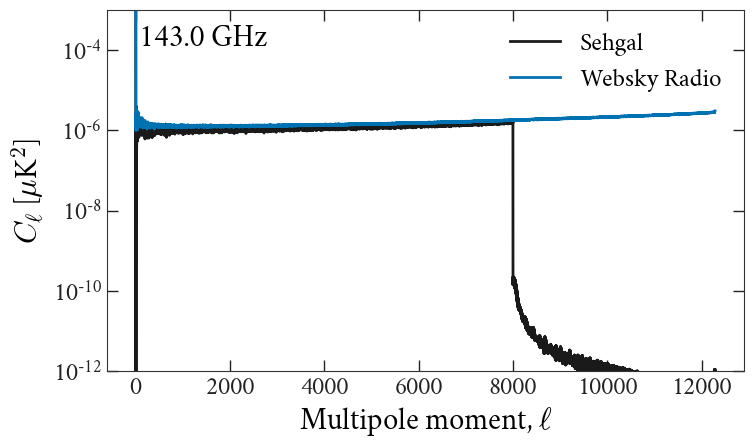

'Cochineal-Roman.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


In [27]:

plt.text(0.05,0.9,"$(freq) GHz", transform=plt.gca().transAxes)

plt.plot(alm2cl(alm_radio_sehgal) ./ pixelwindow.^2, "-", label="Sehgal")
plt.plot(parent(cl_radio_radio)  ./ pixelwindow.^2, "-", label="Websky Radio")

plt.yscale("log")
# plt.xscale("log")
# xlim(0,2nside)
ylim(1e-12,1e-3)
# ylabel(raw"$C_{\ell}$ [$\mu$K$^2$]")


plt.xlabel(raw"Multipole moment, $\ell$")
plt.ylabel(raw"$C_{\ell}$ [$\mu$K$^2$]")
legend()
plt.tight_layout()
plt.savefig("compare_sehgal_websky_radio_spectra_143.pdf")

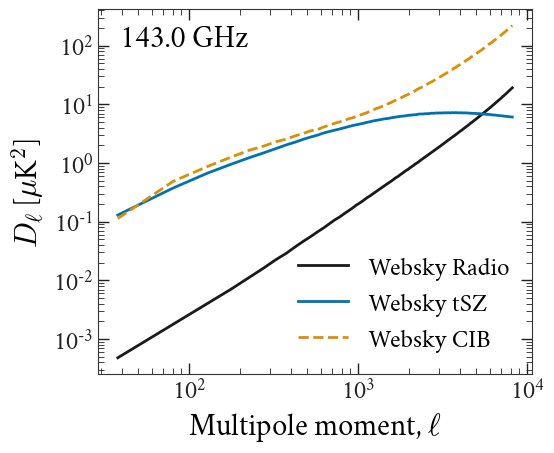

'Cochineal-Roman.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


In [28]:
# plt.plot(radio_model ./ ells.^2 / 2π, "-", lw=2)

plt.figure(figsize=(6,5))
# title("$(freq) GHz")
plt.text(0.05,0.9,"$(freq) GHz", transform=plt.gca().transAxes)


Dl_factor = lb .* (lb .+ 1) ./ (2π)

plt.plot(lb, P * (parent(cl_radio_radio) ./ pixelwindow.^2) .* Dl_factor, "-", label="Websky Radio")

plt.plot(lb, P * (parent(cl_tsz_tsz) ./ pixelwindow.^2) .* Dl_factor  , "-", label="Websky tSZ")
plt.plot(lb, P * (parent(cl_cib_cib) ./ pixelwindow.^2) .* Dl_factor , "--", label="Websky CIB")
# plt.plot(lb, P * (cl_cib_cib_sehgal ./ pixwin.^2).* lb.^2, "-", label="sehgal CIB")

plt.xlabel(raw"Multipole moment, $\ell$")
plt.ylabel(raw"$D_{\ell}$ [$\mu$K$^2$]")


# plt.plot(lb, P * (cl_tsz_tsz .* 2e12), "-")
legend()
plt.yscale("log")
plt.xscale("log")
plt.tight_layout()
# ylim(1e-2, 1e3)
savefig("spectra143.pdf")
# ylim(0,1e-4)

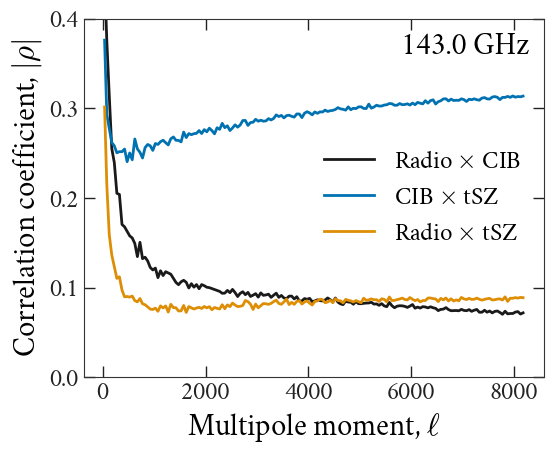

'Cochineal-Roman.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


In [33]:


plt.figure(figsize=(6,5))
plt.text(0.69,0.9,"$(freq) GHz", transform=plt.gca().transAxes)
plot(lb, P * (parent(cl_radio_cib) ./ sqrt.(abs.(parent(cl_radio_radio .* cl_cib_cib))) ), 
    "-", label=raw"Radio $\times$ CIB")
plot(lb, P * abs.(parent(cl_cib_tsz) ./ sqrt.(abs.(parent(cl_tsz_tsz .* cl_cib_cib))) ), 
    "-", label=raw"CIB $\times$ tSZ")
plot(lb, P * abs.(parent(cl_radio_tsz) ./ sqrt.(abs.(parent(cl_radio_radio .* cl_tsz_tsz))) ), 
    "-", label=raw"Radio $\times$ tSZ")
ylabel(raw"Correlation coefficient, $|\rho|$")
plt.xlabel(raw"Multipole moment, $\ell$")
ylim(0.0, 0.4)
plt.legend()
plt.tight_layout()
savefig("correlations_143.pdf")